In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import torch
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
# set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [7]:
# load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
# load data
data = pd.read_excel('training_set_20230608.xlsx')
sentences = data['text'].values
labels = data['label'].values

In [9]:
# tokenize & encode data
input_ids = [tokenizer.encode(sent, add_special_tokens = True) for sent in sentences]

In [10]:
# set maximum sequence length
max_len = 128

# pad and truncate sequences
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")

In [11]:
# creating attention masks
attention_masks = []
for seq in input_ids:
    seq_mask = [int(token_id != tokenizer.pad_token_id) for token_id in seq]
    attention_masks.append(seq_mask)

In [12]:
# split data into train and test sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.1)

In [ ]:
#NAO RODAR ESTA PARTE
#Adjusting tensor size for labels in Train
# one_hot_labels_train = []
# for label in train_labels:
#     if label == "positive":
#         one_hot_labels_train.append([1, 0, 0])
#     elif label == "negative":
#         one_hot_labels_train.append([0, 1, 0])
#     else:
#         one_hot_labels_train.append([0, 0, 1])

# #Adjusting tensor size in Test
# one_hot_labels_test = []
# for label in test_labels:
#     if label == "positive":
#         one_hot_labels_test.append([1, 0, 0])
#     elif label == "negative":
#         one_hot_labels_test.append([0, 1, 0])
#     else:
#         one_hot_labels_test.append([0, 0, 1])

# # Convert all inputs and labels into torch tensors, the required datatype 
# # for our model.
# train_inputs = torch.tensor(train_inputs)
# test_inputs = torch.tensor(test_inputs)

# train_labels = torch.tensor(one_hot_labels_train, dtype=torch.long)
# test_labels = torch.tensor(one_hot_labels_test, dtype=torch.long)

# train_masks = torch.tensor(train_masks)
# test_masks = torch.tensor(test_masks)

In [13]:
#Converting labels into numbers
label_map = {"positive": 1, "negative": 0, "neutral": 0.5}
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)

In [14]:
# create DataLoader objects
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# set optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5)

<ipython-input-14-fef89d54c0bc>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
<ipython-input-14-fef89d54c0bc>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Auxiliary Functions

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
# fine-tune model
epochs = 4
loss_values = []
for epoch in range(epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # ========================================
    #               Training
    # ========================================

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
            
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        total_loss += outputs[0].item()
        outputs[0].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Tracking variables
    model.eval()
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in test_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Average training loss: 1.15
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.57
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Average training loss: 0.86
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.57
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...
  Average training loss: 0.88
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.57
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
Training...
  Average training loss: 0.82
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.57
  Validation took: 0:00:00

Training complete!


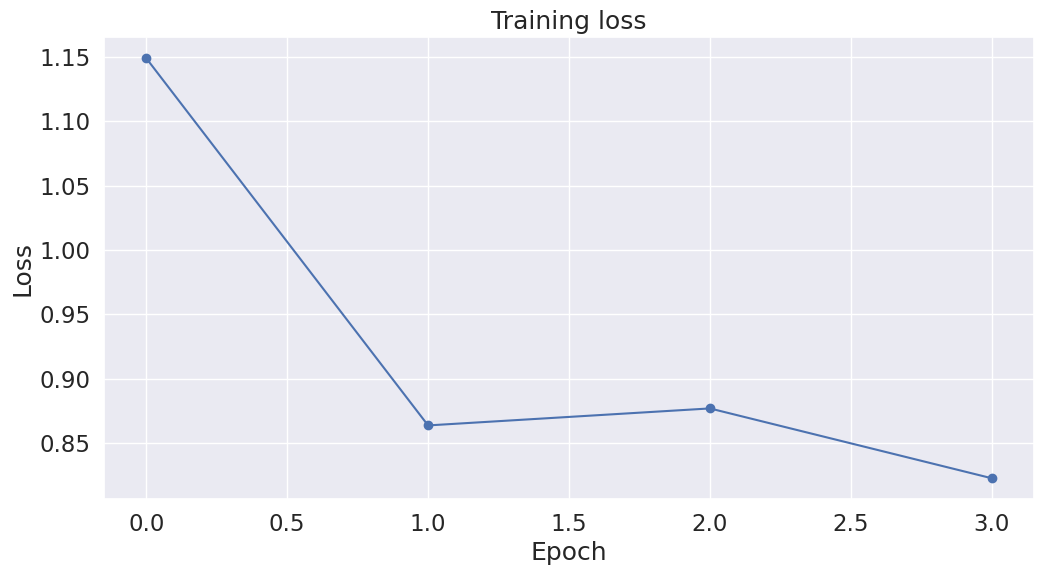

In [17]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Save Model

In [18]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

# Performance On Test Set

In [20]:
df = data.iloc[0:90,:]

In [ ]:
# Load the dataset into a pandas dataframe.
# df = pd.read_csv("test.csv", delimiter=';')

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values
labels = df.label.values
labels = [label_map[label] for label in labels]

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

MAX_LEN = 120
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 90



# Evaluate on Test Set

In [21]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

NameError: ignored

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (sum(labels), len(df.label), (sum(labels) / len(df.label) * 100.0)))

Positive samples: 50 of 90 (56.11%)


In [ ]:
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 3-column ndarray (one column for "0", one column for "1" and one column for "0.5"). 
  # Pick the label with the highest value and turn this in to a list of 0s and 1s.
  pred_labels_i = np.array(get_prediction_list(predictions)).flatten()
  
  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


ValueError: ignored

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

ValueError: ignored

In [19]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

# Accuracy

In [20]:
import numpy as np

def get_prediction_list(predictions):
    prediction_list = []
    for i in range(len(predictions)):
        pred_list = []
        for j in range(len(predictions[i])):
            if predictions[i][j] >= 1:
                pred_list.append(1)
            elif predictions[i][j] <= 0:
                pred_list.append(0)
            else:
                pred_list.append(predictions[i][j])
        prediction_list.append(pred_list)
    return prediction_list

predictions = np.array([[ 2.0494795 , -0.39306873, -1.7465267 ],
                        [ 2.0992174 , -0.10872526, -1.8551859 ],
                        [ 0.43992501,  1.2837973 , -1.6225626 ],
                        [ 1.9611976 , -0.3571208 , -1.6793169 ],
                        [ 0.5082759 ,  1.2165924 , -1.904658  ]])

prediction_list = np.array(get_prediction_list(predictions)).flatten()
print(prediction_list)


[1.         0.         0.         1.         0.         0.
 0.43992501 1.         0.         1.         0.         0.
 0.5082759  1.         0.        ]


# PREDICT TEXT

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import shutil
import os
import logging
import sys
import pickle
import time
import datetime
sys.path.append("..")

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from transformers import AutoModelForSequenceClassification, AutoTokenizer

import nltk 
nltk.download("punkt")

from IPython import get_ipython
ipython = get_ipython()

if '__IPYTHON__' in globals():
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

project_dir = Path.cwd().parent
pd.set_option('max_colwidth', None)

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.ERROR)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('model_save', output_attentions = True)
label_list = ['positive', 'neutral', 'negative']

Useful functions

In [ ]:
def get_split(text_input):

    l_total = []
    l_parcial = []

    if len(text_input.split())//150 > 0:
        n = len(text_input.split())//150
    else:
        n = 1

    for w in range(n):
        if w == 0:
            l_parcial = text_input.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text_input.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

def change_range(df, 
                min_v, 
                max_v):
    lst = []
    for i in range(0, len(df)):
        old_value = df[i]
        old_min = min_v
        old_max = max_v
        new_min = 0
        new_max = 1
    
        new_value = ((old_value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
        lst += [new_value]
    
    return lst

In [ ]:
from finbert.finbert import *

In [ ]:
ls_dates_file = 'copom_dates.xlsx'
pickle_minutes = 'minutes.pkl'
pickle_scores = 'minutes_scores_finbert_20230430.pkl'

def minute_score():

        t0 = time.time()
    
        minutes_df = pd.read_pickle(pickle_minutes)

        i = 0
        minute_score_ls = []
        for minute in minutes_df.minutes:
            i += 1
            print(f'ESTAMOS NA ATA NÚMERO {i} #########################################')
            if isinstance(minute, float):
                minute_score_ls.append(0)
            else:
                textos = pd.DataFrame(minute.split('\n'), columns = ['Text'])
                textos['Result'] = ""

                for d in range(0, len(textos['Text'])):
                    result = predict(textos['Text'][d], model)
                    result['prob_pos'] = result.logit.apply(lambda x:x[0])
                    textos['Result'][d] = result.prob_pos.mean() 

                min_v_a = textos['Result'].min()
                max_v_a = textos['Result'].max()
                textos['Scores_adj'] = np.array(change_range(df = textos['Result'], min_v = min_v_a, max_v = max_v_a))

                minute_score_ls.append(textos['Scores_adj'].mean()*100)
        
        minutes_df['score'] = minute_score_ls

        minutes_df.to_pickle(pickle_scores)

        print("Minute scoring took: {:}".format(format_time(time.time() - t0)))

        return minute_score_ls

In [ ]:
teste = minute_score()

ESTAMOS NA ATA NÚMERO 1 #########################################
ESTAMOS NA ATA NÚMERO 2 #########################################
ESTAMOS NA ATA NÚMERO 3 #########################################
ESTAMOS NA ATA NÚMERO 4 #########################################
ESTAMOS NA ATA NÚMERO 5 #########################################
ESTAMOS NA ATA NÚMERO 6 #########################################
ESTAMOS NA ATA NÚMERO 7 #########################################
ESTAMOS NA ATA NÚMERO 8 #########################################
ESTAMOS NA ATA NÚMERO 9 #########################################
ESTAMOS NA ATA NÚMERO 10 #########################################
ESTAMOS NA ATA NÚMERO 11 #########################################
ESTAMOS NA ATA NÚMERO 12 #########################################
ESTAMOS NA ATA NÚMERO 13 #########################################
ESTAMOS NA ATA NÚMERO 14 #########################################
ESTAMOS NA ATA NÚMERO 15 #########################################
ESTA